Business Goal 5: We will identify how Glossier demand is affected by COVID-19 rates and forecast the relationship for the next year.

Technical Proposal: To accomplish this, we will join external COVID-19 rate data to the Glossier subreddit activity data by day. Like above, we will identify the number of posts and comments that Glossier is mentioned in by day. We will also aggregate the total COVID-19 cases by day. To measure the effect of the COVID-19 rates on the demand, we will develop a multivariate time series ML model to forecast disease rates in conjunction with the demand. As mentioned above, this information will also be depicted on line charts to easily see the relationships and patterns between the two variables and the forecasts over time.

Much of this code is adapted from lab 11 of Dr Purna and Dr Hickman's ANLY 560 Time Series course.

In [0]:
# importing the data
import pandas as pd

df = pd.read_csv("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/NLP/glossier_covid.csv")
df.head()

,Unnamed: 0,dt,activity_count,daily_new_cases,cumulative_cases,daily_new_deaths,cumulative_deaths
0,0,2021-01-01,179,1797638,83677827,26840,1936946
1,1,2021-01-02,204,412196,84090023,8543,1945489
2,2,2021-01-03,187,328962,84418985,7884,1953373
3,3,2021-01-04,267,352863,84771848,7819,1961192
4,4,2021-01-05,301,384608,85156456,8838,1970030


In [0]:
# checking for null values
df.isnull().sum()

Out[2]: Unnamed: 0           0
dt                   0
activity_count       0
daily_new_cases      0
cumulative_cases     0
daily_new_deaths     0
cumulative_deaths    0
dtype: int64

In [0]:
# resource: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from matplotlib import pyplot

# Drop first column of dataframe
df = df.iloc[: , 1:]

# datatype parsing
df["dt"] = pd.to_datetime(df["dt"], format="%Y-%m-%d")
df = df.set_index('dt')
df.head()

,activity_count,daily_new_cases,cumulative_cases,daily_new_deaths,cumulative_deaths
dt,,,,,
2021-01-01,179,1797638,83677827,26840,1936946
2021-01-02,204,412196,84090023,8543,1945489
2021-01-03,187,328962,84418985,7884,1953373
2021-01-04,267,352863,84771848,7819,1961192
2021-01-05,301,384608,85156456,8838,1970030


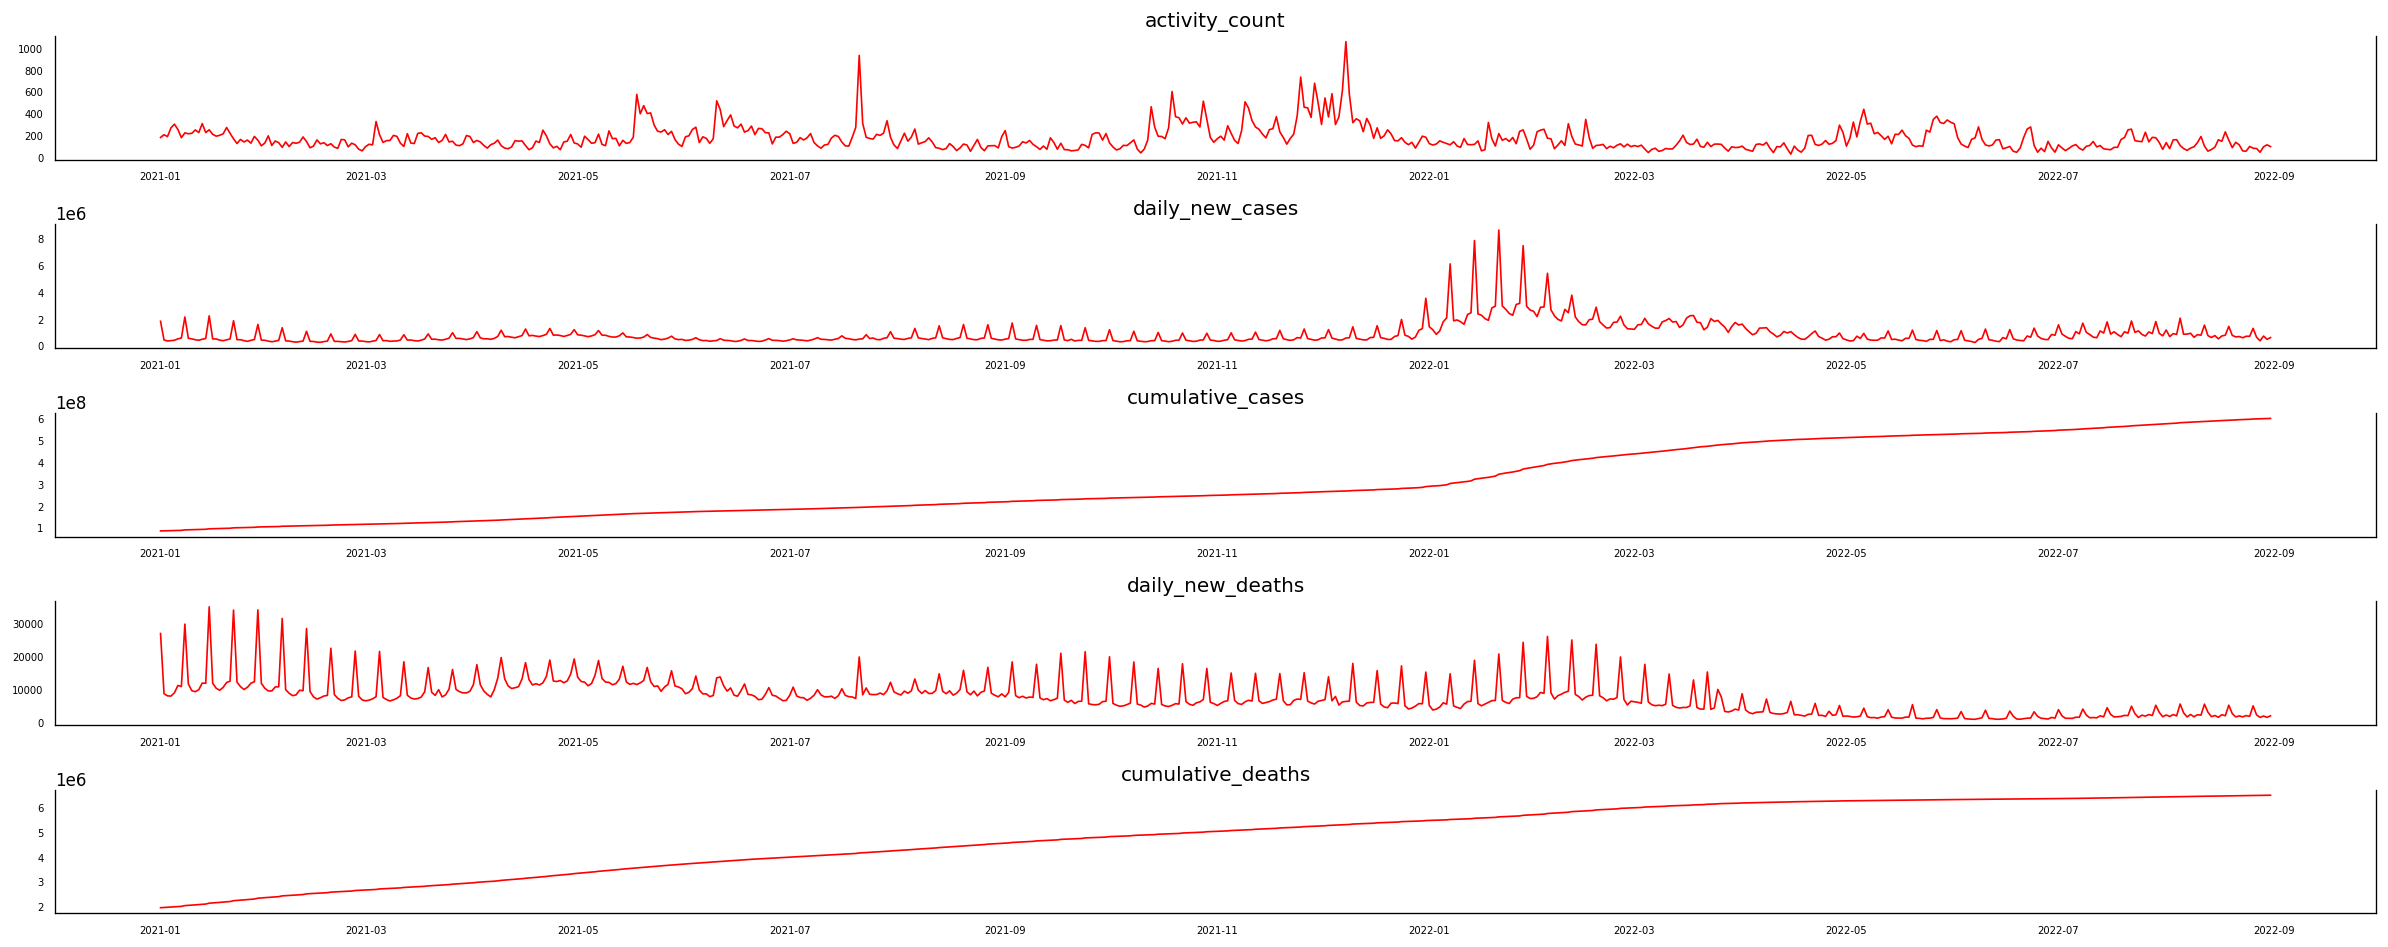

In [0]:
# Plotting the data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(20,8))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [0]:
# let's drop cumulative variables because those are just sums of daily new
df = df.drop(columns=["cumulative_deaths", "cumulative_cases"], axis=1)
df.head()

,activity_count,daily_new_cases,daily_new_deaths
dt,,,
2021-01-01,179,1797638,26840
2021-01-02,204,412196,8543
2021-01-03,187,328962,7884
2021-01-04,267,352863,7819
2021-01-05,301,384608,8838


In [0]:
# inferring the index
# resource: https://stackoverflow.com/questions/49547245/valuewarning-no-frequency-information-was-provided-so-inferred-frequency-ms-wi
df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)

In [0]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=12

test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_table = grangers_causation_matrix(df, variables = df.columns)  
grangers_table

,activity_count_x,daily_new_cases_x,daily_new_deaths_x
activity_count_y,1.0000,0.0,0.0
daily_new_cases_y,0.0001,1.0,0.0
daily_new_deaths_y,0.0000,0.0,1.0


In [0]:
## save the csv file in the csv dir
import os
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/csv/ML", "Q5_grangers_table.csv")
grangers_table.to_csv(fpath)

In [0]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Perform Johanson's Cointegration Test and Report Summary
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
activity_count ::  29.1      > 24.2761   =>   True
daily_new_cases ::  7.1       > 12.3212   =>   False
daily_new_deaths ::  2.6       > 4.1296    =>   False


In [0]:
# predicting 20 values
nobs = 20
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(588, 3)
(20, 3)


In [0]:
# Perform ADFuller to test for Stationarity of given series and print report
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
        
def adjust(val, length= 6): return str(val).ljust(length)

In [0]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

# 1st difference
df_differenced = df_train.diff().dropna()

    Augmented Dickey-Fuller Test on "activity_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.3227
 No. Lags Chosen       = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0139. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "daily_new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8198
 No. Lags Chosen       = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0555. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "daily_new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Dat

In [0]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

# Second Differencing
df_differenced = df_differenced.diff().dropna()

    Augmented Dickey-Fuller Test on "activity_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7448
 No. Lags Chosen       = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "daily_new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1693
 No. Lags Chosen       = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "daily_new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

In [0]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "activity_count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.559
 No. Lags Chosen       = 15
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "daily_new_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7243
 No. Lags Chosen       = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "daily_new_deaths" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

In [0]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  54.12186370974679
BIC :  54.21153779892078
FPE :  3.197621365929836e+23
HQIC:  54.15681150358546 

Lag Order = 2
AIC :  53.55927611824393
BIC :  53.71641296865385
FPE :  1.821795264286473e+23
HQIC:  53.62052016765657 

Lag Order = 3
AIC :  53.19239479385903
BIC :  53.41717286519782
FPE :  1.2623155214570326e+23
HQIC:  53.280008671349755 

Lag Order = 4
AIC :  52.88336352563357
BIC :  53.17596206079083
FPE :  9.26750110675278e+22
HQIC:  52.99742113326614 

Lag Order = 5
AIC :  52.75955854813202
BIC :  53.120157577958
FPE :  8.18848002082355e+22
HQIC:  52.900134119550124 

Lag Order = 6
AIC :  48.56014797395319
BIC :  48.988928322059756
FPE :  1.228668883354163e+21
HQIC:  48.72731607641641 

Lag Order = 7
AIC :  48.094776063200236
BIC :  48.59191935079923
FPE :  7.715135219803303e+20
HQIC:  48.28861159963585 

Lag Order = 8
AIC :  47.92152900418486
BIC :  48.48721765496415
FPE :  6.488226059944501e+20
HQIC:  48.142107215255685 

Lag Order = 9
AIC :  47.76727748904563

In [0]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,55.52,55.54,1.292e+24,55.53
1,54.08,54.17,3.058e+23,54.11
2,53.50,53.66,1.721e+23,53.57
3,53.11,53.34,1.162e+23,53.20
4,52.80,53.10,8.532e+22,52.92
5,52.68,53.04,7.530e+22,52.82
6,48.56,49.00,1.233e+21,48.73
7,48.10,48.60,7.717e+20,48.29
8,47.92,48.50,6.490e+20,48.15
9,47.76,48.40,5.508e+20,48.01


In [0]:
model_fitted = model.fit(13)
model_fitted.summary()

Out[17]:   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Dec, 2022
Time:                     04:03:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    48.0088
Nobs:                     573.000    HQIC:                   47.4531
Log likelihood:          -15812.6    FPE:                2.84805e+20
AIC:                      47.0977    Det(Omega_mle):     2.32611e+20
--------------------------------------------------------------------
Results for equation activity_count
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.006567         3.543024           -0.002           0.999
L1.activity_count           -1.257613         0.044514          -28.252           0.000
L1.daily_new_c

In [0]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

activity_count : 2.02
daily_new_cases : 2.09
daily_new_deaths : 2.04


In [0]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

13


In [0]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

Out[20]: array([[-4.100000e+01, -1.779577e+06, -5.295000e+03],
       [-1.900000e+01,  7.074130e+05,  8.620000e+02],
       [ 1.250000e+02,  6.077600e+05,  1.846000e+03],
       [-1.170000e+02, -9.245960e+05, -9.850000e+02],
       [ 1.350000e+02,  7.132770e+05,  1.031000e+03],
       [-7.800000e+01, -2.782470e+05, -9.670000e+02],
       [-5.500000e+01,  1.269217e+06,  3.982000e+03],
       [ 2.500000e+01, -2.412309e+06, -6.263000e+03],
       [ 1.100000e+01,  1.218074e+06,  1.420000e+03],
       [ 3.800000e+01,  4.157100e+04,  1.985000e+03],
       [-9.000000e+00, -3.540950e+05, -1.416000e+03],
       [ 2.700000e+01,  4.878160e+05,  1.291000e+03],
       [ 1.600000e+01, -2.281730e+05, -7.310000e+02]])

In [0]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast.head()

,activity_count_2d,daily_new_cases_2d,daily_new_deaths_2d
2022-08-12,-78.691853,1.340837e+06,4269.882355
2022-08-13,-13.876165,-2.602091e+06,-7605.996357
2022-08-14,27.496165,1.469336e+06,2521.341370
2022-08-15,10.315291,-4.135563e+05,1411.417730
2022-08-16,46.457572,1.490375e+05,-915.929177


In [0]:
len(df_forecast)

Out[22]: 20

In [0]:
#Revert back the differencing to get the forecast to original scale.
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [0]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['activity_count_forecast', 'daily_new_cases_forecast', 'daily_new_deaths_forecast']]

,activity_count_forecast,daily_new_cases_forecast,daily_new_deaths_forecast
2022-08-12,164.308147,2.069401e+06,6179.882355
2022-08-13,126.740129,7.721900e+05,2722.768353
2022-08-14,116.668277,9.443152e+05,1786.995721
2022-08-15,116.911715,7.028841e+05,2262.640820
2022-08-16,163.612726,6.104905e+05,1822.356742
2022-08-17,150.979941,7.646408e+05,2109.133034
2022-08-18,158.754911,7.400661e+05,1866.120518
2022-08-19,167.458925,1.974458e+06,6808.554644
2022-08-20,158.883402,7.521745e+05,2741.460029
2022-08-21,150.568101,9.900454e+05,2064.305721


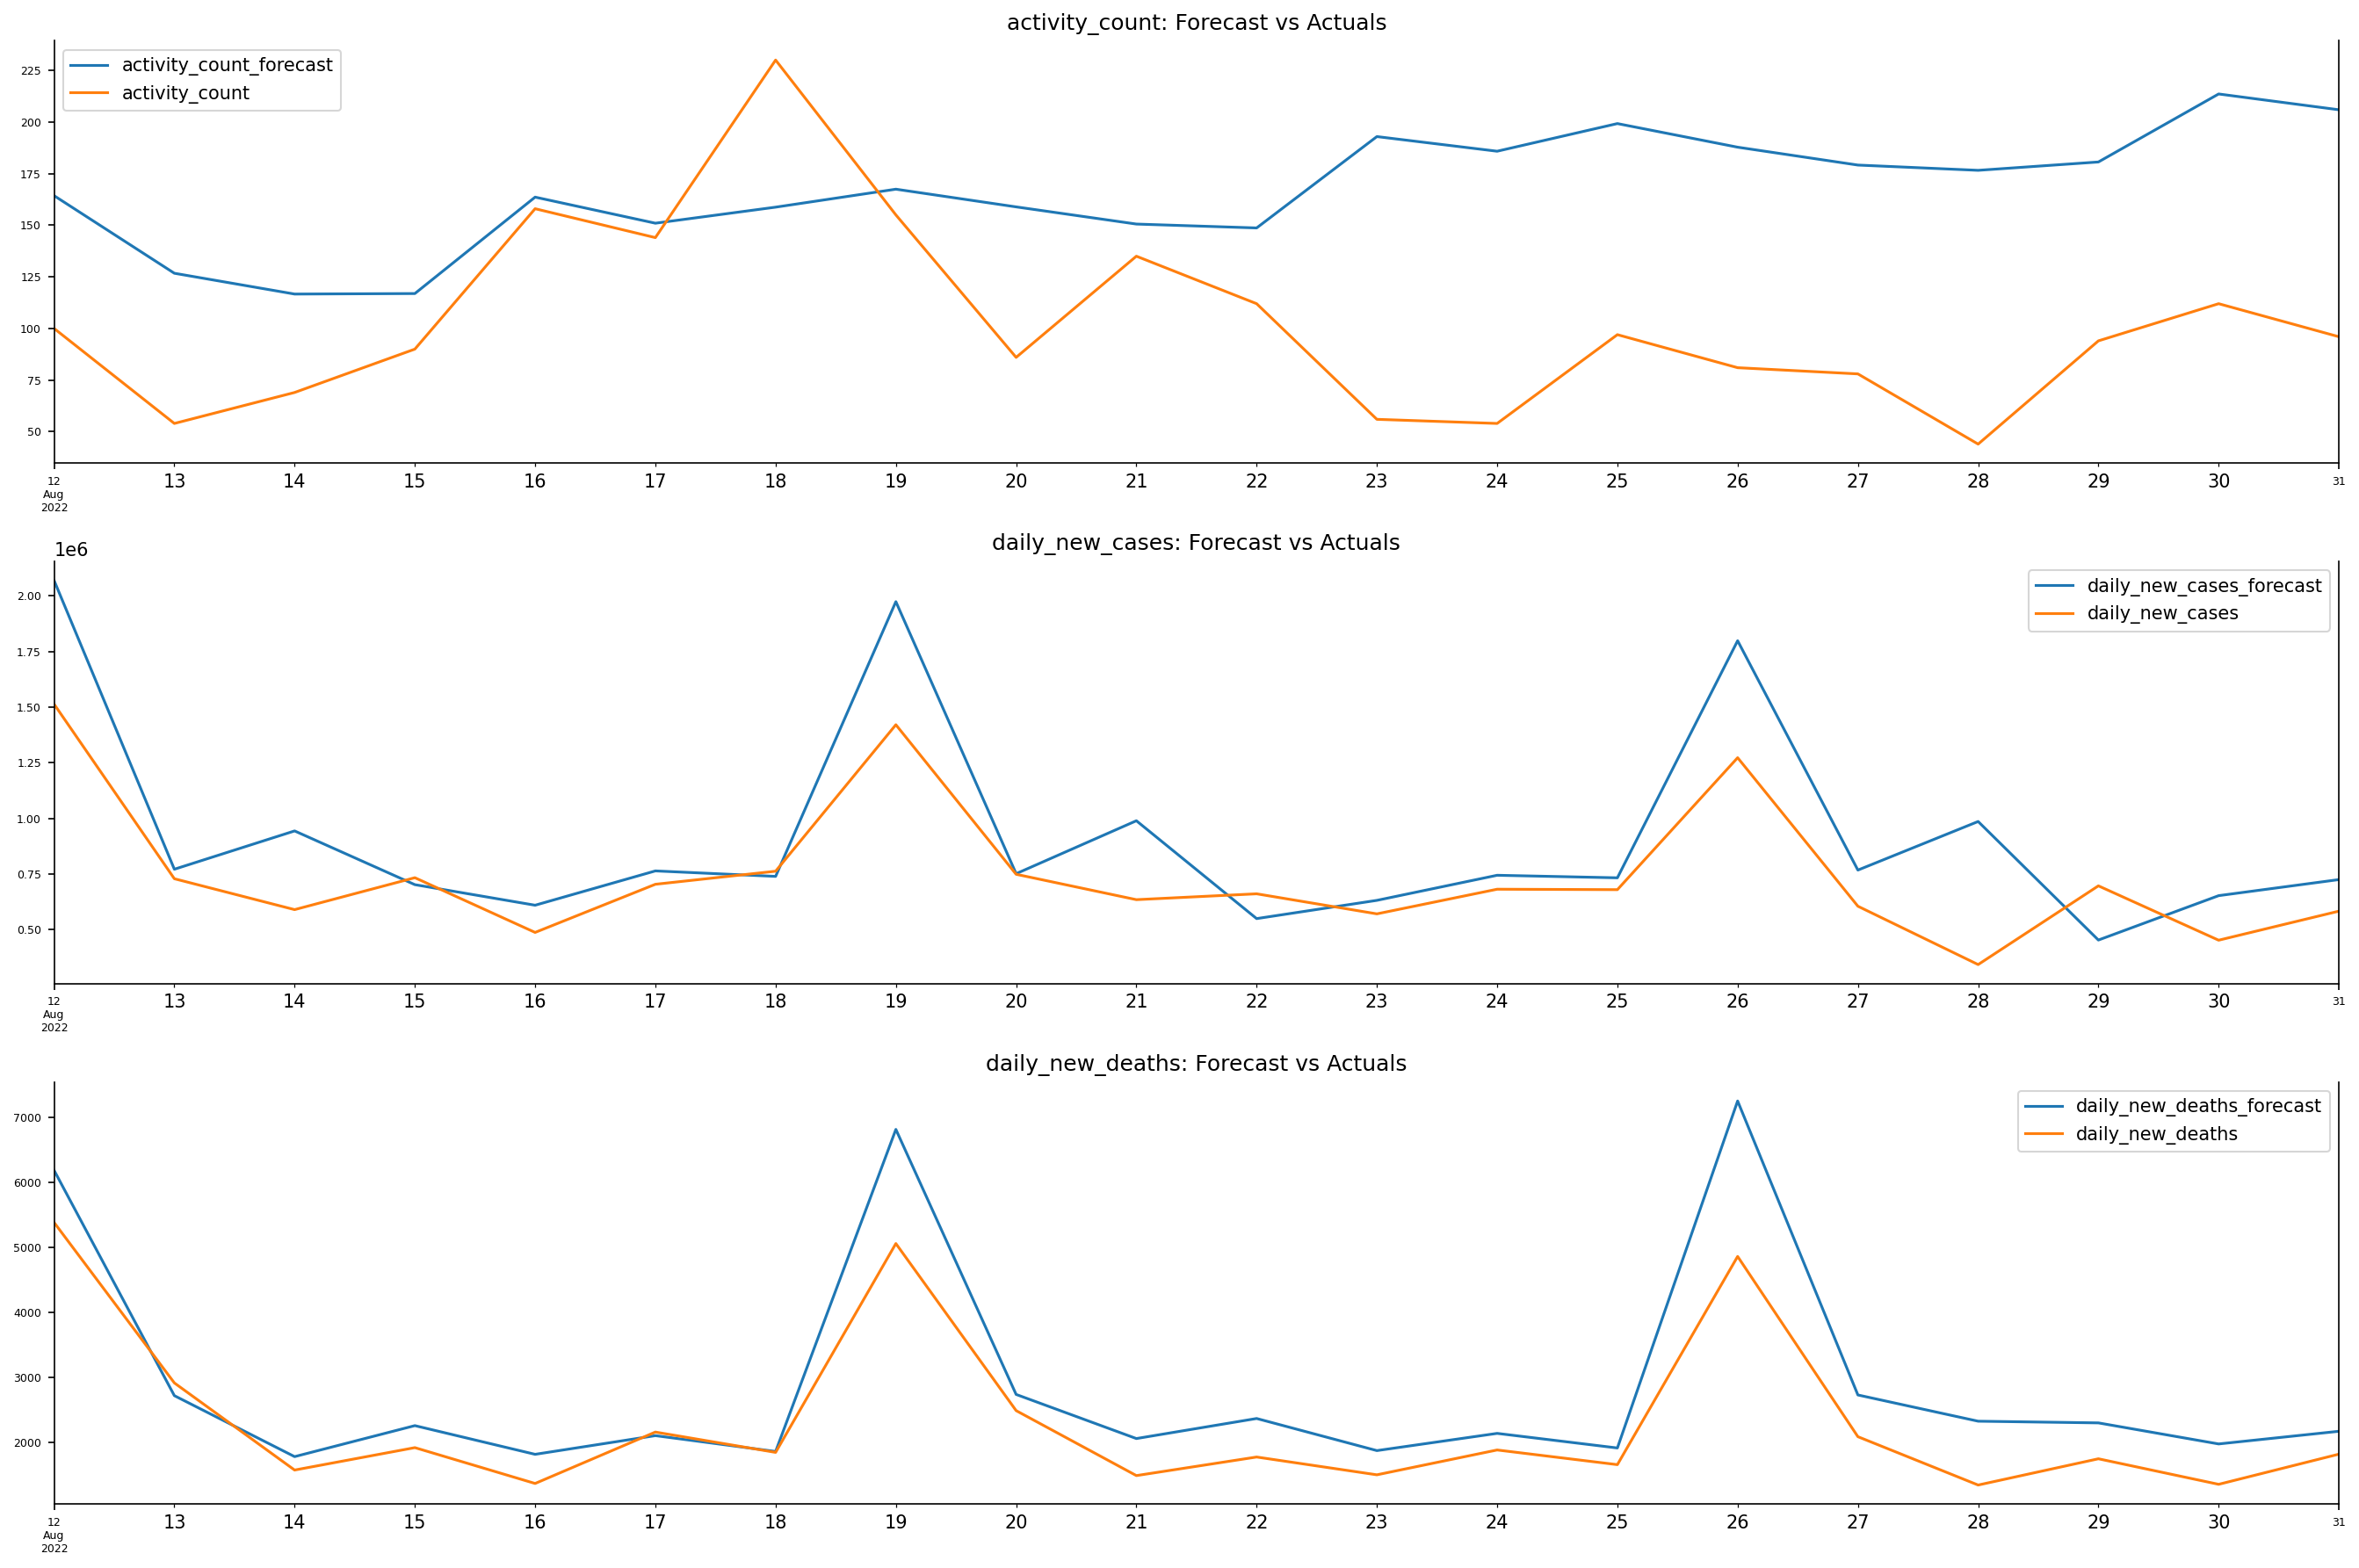

In [0]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=150, figsize=(18, 12))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.savefig('/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/ML/Q5_viz1.png')

In [0]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [0]:
print('Forecast Accuracy of: Glossier Activity')
accuracy_prod = forecast_accuracy(df_results['activity_count_forecast'].values, df_test['activity_count'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Glossier Activity
mape   :  0.9644
me     :  65.0112
mae    :  72.1357
mpe    :  0.9334
rmse   :  83.7666
corr   :  -0.0733
minmax :  0.4092
<command-108853573897133>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<command-108853573897133>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [0]:
print('\nForecast Accuracy of: Daily New Cases')
accuracy_prod = forecast_accuracy(df_results['daily_new_cases_forecast'].values, df_test['daily_new_cases'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Daily New Cases
mape   :  0.3206
me     :  174206.1635
mae    :  215150.0422
mpe    :  0.2615
rmse   :  295395.2792
corr   :  0.8781
minmax :  0.2059
<command-108853573897133>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<command-108853573897133>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [0]:
print('\nForecast Accuracy of: Daily New Deaths')
accuracy_prod = forecast_accuracy(df_results['daily_new_deaths_forecast'].values, df_test['daily_new_deaths'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Daily New Deaths
<command-108853573897133>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
mape   :  0.2528
me     :  556.1573
mae    :  581.1671
mpe    :  0.2436
rmse   :  805.5766
corr   :  0.962
minmax :  0.1879
<command-108853573897133>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
